In [67]:
import numpy as np
import pandas as pd
from polara import get_movielens_data

from sklearn.model_selection import GroupKFold
from ipypb import track # pip-installable

# Task

Develop a recommender systems framework for conducting the necessary experiments, which includes:
- training recsys models
- generating recommendations
- evaluating recommendations quality
- performing model comparison

## Experiment protocol can be described in terms of 4 functions:

```python
# building/training a recommender model
model_params = build_func(model_config, trainset, trainset_description)

# predicting relevance scores for test user-item pairs
model_scores = score_func(model_params, testset, testset_description)

# generating top-n recommendations using predcted scores
model_recoms = recom_func(model_scores, topn)

# evaluating quality of recommendations
recs_quality = evaluate_func(model_recoms, holdout, holdout_description)
```


**Essentially, this is the main functionality provided by most of the recommender systems frameworks.**  
That's why we can say that we're building a simple recsys framework from scratch.

# Preparing Data

In [68]:
data, genres = get_movielens_data(
    get_genres=True,
    split_genres=False,
    include_time=True
)

In [69]:
movies = genres.set_index('movieid')
movies.head()

,movienm,genres
movieid,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [70]:
data.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [71]:
data.apply('nunique')

userid         6040
movieid        3706
rating            5
timestamp    458455
dtype: int64

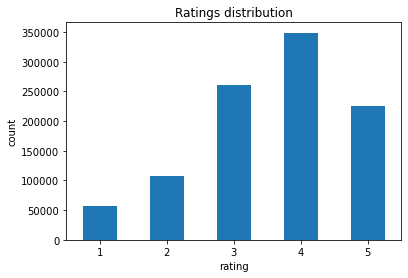

In [72]:
(
    data["rating"]
    .value_counts()
    .sort_index()
    .plot.bar(
        title='Ratings distribution',
        xlabel='rating', ylabel='count',
        rot=0
    )
);

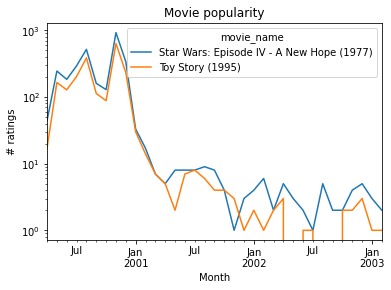

In [73]:
(
    data
    .set_index(pd.to_datetime(data['timestamp'], unit='s'))
    .query('movieid in [1, 260]')
    .assign(movie_name=lambda x: x['movieid'].map(movies['movienm']))
    .groupby('movie_name')
    .resample('M') # monthly
    .size() # total count
    .T
    .plot(logy=True, title='Movie popularity', xlabel='Month', ylabel='# ratings')
);

# Preprocess data

Here, we'll use a simple temporal "leave-last-out" scheme for holdout sampling.  
Note that this scheme is not perfect as it's prone to test data leakage from future interactions.

## Data split

In [74]:
def leave_last_out(data, userid='userid', timeid='timestamp'):
    sorted = data.sort_values(timeid)
    holdout = sorted.drop_duplicates(subset=[userid], keep='last')
    remaining = sorted.drop(holdout.index)
    return remaining, holdout

In [75]:
training, holdout = leave_last_out(data)

In [76]:
assert holdout.set_index('userid')['timestamp'].ge(
    training
    .groupby('userid')
    ['timestamp'].max()
).all()

## Transform index

Source data is not always numeric. Moreover, user and item ids may contain large gaps. We fix that by introducing an internal contiguous numeric index.


In [77]:
def transform_indices(data, users, items):
    data_index = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        idx, idx_map = to_numeric_id(data, field)
        data_index[entity] = idx_map
        data.loc[:, field] = idx
    return data, data_index

def to_numeric_id(data, field):
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map

def reindex_data(data, entity, data_index):
    field = data_index[entity].name
    new_index = data_index[entity].get_indexer(data[field])
    return data.assign(**{f'{field}': new_index})

In [78]:
training, data_index = transform_indices(training, 'userid', 'movieid')

In [79]:
holdout = reindex_data(holdout, 'items', data_index)

In [80]:
data_index['items']

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952],
           dtype='int64', name='movieid', length=3704)

## Data consistency check

We need to ensure that holdout doesn't contain entities that are not present in the training data.

In [81]:
holdout.query('movieid<0')

,userid,movieid,rating,timestamp
6448,46,-1,5,977979487
304604,1812,-1,3,1036451763


In [82]:
holdout = holdout.query('movieid >= 0')

# Random recommendations model

In [83]:
def build_random_model(config, trainset, trainset_description):
    itemid = trainset_description['items']
    n_items = trainset[itemid].max() + 1
    random_state = np.random.RandomState(config['seed'])
    return n_items, random_state

In [84]:
def random_model_scoring(params, testset, testset_description):
    n_items, random_state = params
    n_users = testset_description['n_test_users']
    scores = random_state.rand(n_users, n_items)
    return scores

In [85]:
def simple_model_recom_func(scores, topn=10):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations

def topidx(a, topn):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]

In [86]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    n_test_users = holdout[data_index['users'].name].nunique()
)

In [87]:
rnd_params = build_random_model({'seed': 99}, training, data_description)
rnd_scores = random_model_scoring(rnd_params, None, data_description)
rnd_recoms = simple_model_recom_func(rnd_scores)

In [88]:
data_index['users']

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
           dtype='int64', name='userid', length=6040)

In [89]:
data_description['n_test_users']

6038

In [90]:
rnd_scores.shape

(6038, 3704)

In [91]:
rnd_recoms.shape

(6038, 10)

In [92]:
def display_movies(items_idx):
    # need to convert internal index to external representation
    movie_idx = data_index['items'][items_idx]
    return movies.loc[movie_idx]

In [93]:
display_movies(rnd_recoms[0])

,movienm,genres
movieid,,
2440,Another Day in Paradise (1998),Drama
1665,Bean (1997),Comedy
3820,Thomas and the Magic Railroad (2000),Children's
2092,"Return of Jafar, The (1993)",Animation|Children's|Musical
290,Once Were Warriors (1994),Crime|Drama
731,Heaven's Prisoners (1996),Mystery|Thriller
371,"Paper, The (1994)",Comedy|Drama
3804,H.O.T.S. (1979),Comedy
1005,D3: The Mighty Ducks (1996),Children's|Comedy


# Simple popularity-based model


In [94]:
def build_popularity_model(config, trainset, trainset_description):
    itemid = trainset_description['items']
    item_popularity = trainset[itemid].value_counts()
    return item_popularity

In [95]:
def popularity_model_scoring(params, testset, testset_description):
    item_popularity = params
    n_items = item_popularity.index.max() + 1
    n_users = testset_description['n_test_users']
    # fill in popularity scores for each item with indices from 0 to n_items-1
    popularity_scores = np.zeros(n_items,)
    popularity_scores[item_popularity.index] = item_popularity.values
    # same scores for each test user
    scores = np.tile(popularity_scores, n_users).reshape(n_users, n_items)
    return scores

In [96]:
pop_params = build_popularity_model({}, training, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
pop_recoms = simple_model_recom_func(pop_scores)

In [97]:
display_movies(pop_recoms[0])

,movienm,genres
movieid,,
2858,American Beauty (1999),Comedy|Drama
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
480,Jurassic Park (1993),Action|Adventure|Sci-Fi
2028,Saving Private Ryan (1998),Action|Drama|War
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1270,Back to the Future (1985),Comedy|Sci-Fi


# Evaluating recommendations quality

We will use **HitRate** (HR) и **Mean Reciprocal Rank** (MRR).  
*Note*: In the case of a single holdout item per user the latter coincides with the Average Reciprocal HitRate (ARHR) and Mean Average Precision (MAP).

$$
\text{HR} = \frac{1}{\text{\# test users}} \sum_{\text{test users}}{hit}, \quad
$$

$$
hit = 
\begin{gather*}
\begin{cases}
  1 & \text{if holdout item in top-$n$ recommendations,}\\    
  0 & \text{otherwise.}
\end{cases}
\end{gather*}
$$

$$
\text{MRR} = \frac{1}{\text{\# test users}} \sum_{\text{test users}}{\frac{1}{\text{hit rank}}}
$$

In [98]:
rnd_recoms.shape

(6038, 10)

In [99]:
rnd_hits_mask = rnd_recoms == holdout['movieid'].values.reshape(-1, 1)

In [100]:
rnd_hits_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [101]:
rnd_hits_mask.shape

(6038, 10)

In [102]:
rnd_hr = np.mean(
    rnd_hits_mask.any(axis=1)
)
print(f'{rnd_hr=:.4f}')

rnd_hr=0.0013


In [103]:
_, rnd_hits_rank = np.where(rnd_hits_mask)

In [104]:
rnd_hits_rank

array([5, 2, 9, 6, 7, 6, 8, 7])

In [105]:
n_test_users = holdout.shape[0]
rnd_mrr = np.sum(1 / (rnd_hits_rank+1.)) / n_test_users
print(f'{rnd_mrr=:.4f}')

rnd_mrr=0.0002


## Evaluation function

In [106]:
def model_evaluate(recommended_items, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    return hr, mrr

In [107]:
rnd_recoms.max()

3703

In [108]:
holdout

,userid,movieid,rating,timestamp
998335,6034,881,5,956712388
998435,6035,2929,1,956713640
998312,6033,1539,1,956714112
999731,6038,1094,5,956717204
998139,6031,354,4,956718589
...,...,...,...,...
59497,403,971,4,1046388675
511804,3158,2445,4,1046393499
983967,5948,2881,4,1046437932
879288,5312,3042,4,1046444711


In [109]:
model_evaluate(rnd_recoms, holdout, data_description)

(0.001324942033786022, 0.00020649642213073813)

In [110]:
model_evaluate(pop_recoms, holdout, data_description)

(0.020370983769460085, 0.007026990436231906)

<font color=green>  

* The obtained results are metrics@<...>?
* What is the obvious way of improving the obtained results? Hint: we miss something in our scoring functions.
* How do we get confidence intervals and estimate statistical significance of the results?  
* What requirements our models would have to satisfy?
* What changes do we need to make in order to assess strong generalization?

</font>

# Cross-validation example

Let's assume there's no dependence of user consumption pattern on time data (or at leastwe ar not interested in it). In that case, temporal splitting is not necessary and we can switch to e.g. random sampling strategy. 

Our methodology will be:
- random "leave-one-out" sampling for holdout items
- use $k$-fold cross-validation scheme,
- test against strong generalization of models.

## CV boilerplate

### data preparation routines

In [111]:
def leave_one_out(data, data_descirption, seed=None):
    shuffled = data.sample(frac=1, random_state=seed)
    holdout = shuffled.drop_duplicates(subset=[data_descirption['users']], keep='last')
    remaining = data.drop(holdout.index)
    return remaining, holdout

def train_test_split(test_index, data, data_description, seed, holdout_sampling=None):
    userid = data_description['users']
    itemid = data_description['items']
    if holdout_sampling is None:
        holdout_sampling = leave_one_out
    # split train/test and build internal index
    test_data_ = data.iloc[test_index]
    training_ = data.drop(test_data_.index)
    training, data_index = transform_indices(training_, userid, itemid)
    # conform test data with internal index
    test_data = (
        reindex_data(test_data_, 'items', data_index)
        .query(f'{itemid} >= 0')
    )
    # note: we haven't reindexed user ids in our simple example
    # but in general we need to perform user reindexing as well

    # split holdout
    testset, holdout = holdout_sampling(test_data, data_description, seed=seed)
    # ensure user index consistency in test data
    # due to warm-start condition, we don't need to check
    # for consistency with the training data
    same_test_users = testset[userid].isin(holdout[userid])
    if not same_test_users.all():
        testset = testset[same_test_users]
    # sort by users for convenience and conformity
    testset = testset.sort_values(userid)
    holdout = holdout.sort_values(userid)
    return training, testset, holdout, data_index

### CV routines

In [112]:
metrics = ['HR', 'MRR']

In [113]:
def run_kfold_cv(
    data, data_description,
    models, configs,
    build_funcs, score_funcs,
    recom_func, eval_func,
    *,
    k_folds=5,
    topn_list=None,
    seed=None,
    fold_experiment=None,
    **kwargs
): 
    # perform basic checks
    assert len(configs) == len(models) == len(build_funcs) == len(score_funcs)
    if fold_experiment is None:
        fold_experiment = run_fold_experiment
    if topn_list is None:
        topn_list = [10]
    # initiate experiment
    kfold = GroupKFold(n_splits=k_folds)
    user_groups = data[data_description['users']]
    results = []
    for train_idx, test_idx in track(kfold.split(data, groups=user_groups), k_folds):
        fold_data = train_test_split(test_idx, data, data_description, seed)
        fold_res = fold_experiment(
            fold_data, data_description,
            models, configs,
            build_funcs, score_funcs,
            recom_func, eval_func,
            topn_list,
            **kwargs
        )
        results.append(fold_res)
    return results


def run_fold_experiment(
    fold_data, data_description,
    models,  configs,
    build_funcs, score_funcs,
    recom_func, eval_func,
    topn_list
):
    fold_results = {model: {metric: [] for metric in metrics} for model in models}
    topn_max = max(topn_list)
    # unpack experiment data
    training, testset, holdout, data_index = fold_data
    testset_description = {
        **data_description,
        'n_test_users': testset[data_description['users']].nunique()
    }
    # run experiment
    for model, build_func, score_func, model_config in zip(models, build_funcs, score_funcs, configs):
        model_params = build_func(model_config, training, testset_description)
        model_scores = score_func(model_params, testset, testset_description)
        model_recoms = recom_func(model_scores, topn=max(topn_list))
        for topn in topn_list:
            hr, mrr = eval_func(model_recoms, holdout, data_description, topn=topn)
            fold_results[model]['HR'].append(hr)
            fold_results[model]['MRR'].append(mrr)
    return fold_results

pop_params = build_popularity_model({}, training, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
pop_recoms = simple_model_recom_func(pop_scores)

## run experiment

In [114]:
model_names = ['most popular', 'random']
model_configs = [{}, {'seed': 0}]
model_build_funcs = [build_popularity_model, build_random_model]
models_scoring = [popularity_model_scoring, random_model_scoring]
topn_list = [1, 5, 10]

results = run_kfold_cv(
    data, data_description,
    model_names, model_configs,
    model_build_funcs, models_scoring,
    simple_model_recom_func, model_evaluate,
    k_folds=4, topn_list=topn_list
)

 [████████████████████████████████████████████████████████████] 4/4 [00:01<00:00, 0.22s/it]

In [115]:
results

[{'most popular': {'HR': [0.006622516556291391,
    0.02847682119205298,
    0.046357615894039736],
   'MRR': [0.006622516556291391, 0.01347682119205298, 0.01595895090928203]},
  'random': {'HR': [0.0, 0.0006622516556291391, 0.0013245033112582781],
   'MRR': [0.0, 0.00016556291390728477, 0.0002759381898454746]}},
 {'most popular': {'HR': [0.007947019867549669,
    0.02384105960264901,
    0.04304635761589404],
   'MRR': [0.007947019867549669, 0.012615894039735098, 0.015061494796594133]},
  'random': {'HR': [0.0006622516556291391,
    0.0013245033112582781,
    0.0033112582781456954],
   'MRR': [0.0006622516556291391,
    0.0009933774834437086,
    0.0012233259749816043]}},
 {'most popular': {'HR': [0.004635761589403974,
    0.02913907284768212,
    0.04701986754966887],
   'MRR': [0.004635761589403974, 0.012660044150110373, 0.015144013455271733]},
  'random': {'HR': [0.0006622516556291391,
    0.0013245033112582781,
    0.003973509933774834],
   'MRR': [0.0006622516556291391,
    0.000

# Results analysis

In [116]:
def results_to_df(results, topn_list):
    metric_index = pd.MultiIndex.from_product(
        [metrics, topn_list],
        names=['metric', 'topn']
    )
    results_df = pd.concat(
        {
            foldid: pd.DataFrame(res)
            .explode(column=list(res.keys()))
            .set_index(metric_index)
            for foldid, res in enumerate(results, start=1)
        },
        names=['fold']
    )
    return results_df

In [117]:
results_df = results_to_df(results, topn_list)
results_df.head(10)

most popular    random
fold metric topn                       
1    HR     1        0.006623       0.0
            5        0.028477  0.000662
            10       0.046358  0.001325
     MRR    1        0.006623       0.0
            5        0.013477  0.000166
            10       0.015959  0.000276
2    HR     1        0.007947  0.000662
            5        0.023841  0.001325
            10       0.043046  0.003311
     MRR    1        0.007947  0.000662

In [118]:
results_df.groupby(level=['metric', 'topn']).mean()

most popular    random
metric topn                        
HR     1         0.005464  0.000331
       5         0.025828  0.001490
       10        0.046358  0.002980
MRR    1         0.005464  0.000331
       5         0.011959  0.000792
       10        0.014712  0.000991

In [119]:
results_df.groupby(level=['metric', 'topn']).std()

most popular    random
metric topn                        
HR     1         0.002318  0.000382
       5         0.003546  0.000833
       10        0.002478  0.001147
MRR    1         0.002318  0.000382
       5         0.001957  0.000418
       10        0.001412  0.000489

<font color=green>

- Do we actually measure user satisfaction with the implemented sampling? Why?
- Suggest an evaluation protocol to measure potential satisfaction better.

</font>

# Significance test

In [120]:
from polara.evaluation.evaluation_engine import sample_ci

In [121]:
sample_ci(results_df.unstack('metric'), level='topn')

/Users/scalyvladimir/miniforge3/envs/firstEnv/lib/python3.8/site-packages/polara/evaluation/evaluation_engine.py:25: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.var(level=1) should use df.groupby(level=1).var().
  return coef * df.std(level=level, ddof=1) / sqrt(n)


most popular              random          
metric           HR       MRR        HR       MRR
topn                                             
1          0.003217  0.003217  0.000531  0.000531
5          0.004922  0.002717  0.001157  0.000580
10         0.003439  0.001960  0.001592  0.000679

# Using Polara

In [122]:
from polara import RecommenderData, RandomModel, PopularityModel

## Temporal split example

In [123]:
data_config = dict(
    warm_start = False,
    holdout_size = 1,
    test_ratio = 0, # split holdout from all users
    random_holdout = False, # use either feedback or custom_order field
)
dm = RecommenderData(
    data, 'userid', 'movieid', 'rating',
    custom_order='timestamp', config=data_config
)


In [124]:
print(dm)

RecommenderData with Fields(userid='userid', itemid='movieid', feedback='rating')


In [125]:
dm.prepare()

Preparing data...
2 unique movieid entities within 2 holdout interactions were filtered. Reason: not in the training data.
Done.
There are 994169 events in the training and 6038 events in the holdout.


In [126]:
pop = PopularityModel(dm)
pop.build()
pop.evaluate()

/Users/scalyvladimir/miniforge3/envs/firstEnv/lib/python3.8/site-packages/scipy/sparse/data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


[Relevance(hr=0.03627028817489235),
 Ranking(arhr=0.012338456968301286, mrr=0.012338456968301287),
 Experience(coverage=0.05372570194384449),
 Hits(true_positive=219, false_positive=60161, true_negative=None, false_negative=5819)]

In [127]:
rnd = RandomModel(dm, seed=0)
rnd.build()
rnd.evaluate()

[Relevance(hr=0.001987413050679033),
 Ranking(arhr=0.0005363517826253831, mrr=0.0005363517826253831),
 Experience(coverage=1.0),
 Hits(true_positive=12, false_positive=60368, true_negative=None, false_negative=6026)]

## Cross-validation example

In [128]:
from polara.evaluation import evaluation_engine as ee

In [129]:
dm = RecommenderData(data, 'userid', 'movieid', 'rating')

dm.warm_start = True
dm.holdout_size = 1
dm.test_ratio = 0.2 # split holdout from all users
dm.random_holdout = True # sample randomly
dm.verbose = False # don't print data update info

In [130]:
dm.get_configuration()

The value of holdout_size might be not effective yet.
The value of random_holdout might be not effective yet.


{'holdout_size': 1,
 'negative_prediction': False,
 'test_ratio': 0.2,
 'permute_tops': False,
 'test_sample': None,
 'random_holdout': True,
 'test_fold': 5,
 'shuffle_data': False,
 'warm_start': True}

In [131]:
topk_values = [1, 5, 10]
models = [RandomModel(dm, seed=0), PopularityModel(dm)]

# run CV experiment
results = ee.run_cv_experiment(
    models,
    fold_experiment=ee.topk_test,
    topk_list=topk_values,
    iterator=track
)

 [████████████████████████████████████████████████████████████] 5/5 [00:01<00:00, 0.22s/it]

/Users/scalyvladimir/miniforge3/envs/firstEnv/lib/python3.8/site-packages/scipy/sparse/data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [132]:
results.loc[:, :'experience'].groupby(level=['top-n', 'model']).mean()

type        relevance   ranking           experience
metric             hr      arhr       mrr   coverage
top-n model                                         
1     MP     0.014241  0.014241  0.014241   0.009899
      RND    0.000828  0.000828  0.000828   0.278482
5     MP     0.045372  0.024844  0.024844   0.023226
      RND    0.002152  0.001286  0.001286   0.797275
10    MP     0.075178  0.028754  0.028754   0.034811
      RND    0.003477  0.001458  0.001458   0.958455

# Helpers

In [ ]:
def downvote_seen_items(scores, data, data_description):
    itemid = data_description['items']
    userid = data_description['users']
    # get indices of observed data
    sorted = data.sort_values(userid)
    item_idx = sorted[itemid].values
    user_idx = sorted[userid].values
    user_idx = np.r_[False, user_idx[1:] != user_idx[:-1]].cumsum()
    # downvote scores at the corresponding positions
    seen_idx_flat = np.ravel_multi_index((user_idx, item_idx), scores.shape)
    np.put(scores, seen_idx_flat, scores.min() - 1)